# 이미지 Dataset 만들기 - glob과 Dataset from_tensor_slices 활용
+ 본과정에서는 콘크리트 이미지 데이터를 가지고 모델 학습에 사용할 DataSet을 만들어서 이미지 분류 실습하겠습니다.
+ 먼저, 콘크리트 이미지 데이터를 glob, from_tensor_slices, Pipeline을 활용해서 DataSet을 만들겠습니다.
+ 그리고, 모델 학습하기 위해서는 DataSet뿐아니라 라벨정보도 필요하기에
+ 라벨정보 포함되도록 Dataset을 만들고 이를 이용해서 모델 구축해 보겠습니다.

### 학습목차
#### A. 이미지 데이터셋 만들기(라벨 정보 없음)

1. 필요한 라이브러리 임포트
2. 이미지 파일 가져오기 : concrete_image.zip
3. 이미지 파일 하나 읽어 이미지 보기
4. glob과 from_tensor_slices , Pipeline 이용하여 이미지 데이터셋 만들기

#### B. 라벨정보 포함한 이미지 데이터셋 만들기(많은 수작업 필요)
1. glob 이용하여 이미지 패스 읽기
2. shuffle
3. Train/Test 비율로 나누기
4. 이미지 라벨링 만들기
5. from_tensor_slices > map > cache > batch > shuffle > prefetch 파이프라인 사용하여 이미지/라벨링 데이터셋 만들기

#### C. Build Model
1. Build Model
2. Callback
3. 모델 학습
4. 성능 그래프
5. Predict

## A. 이미지 데이터셋 만들기(라벨 정보 없음)

### 1.필요한 라이브러리 임포트

In [ ]:
import os
from glob import glob

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

### 2.이미지 파일 가져오기 : concrete_image.zip

In [ ]:
# 업로드 concrete_image.zip 파일 확인
glob('concrete_image.zip')

['concrete_image.zip']

In [ ]:
# 이미지 폴더 생성 및 concrete_image.zip 파일 압축 풀기 > 3,000개 이미지로 실습을 위해 데이터 축소

if not os.path.exists('IMAGE'):
    os.mkdir('IMAGE')
    !unzip concrete_image.zip -d IMAGE

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: IMAGE/Negative/01002.jpg  
  inflating: IMAGE/Negative/01003.jpg  
  inflating: IMAGE/Negative/01004.jpg  
  inflating: IMAGE/Negative/01005.jpg  
  inflating: IMAGE/Negative/01006.jpg  
  inflating: IMAGE/Negative/01007.jpg  
  inflating: IMAGE/Negative/01008.jpg  
  inflating: IMAGE/Negative/01009.jpg  
  inflating: IMAGE/Negative/01010.jpg  
  inflating: IMAGE/Negative/01011.jpg  
  inflating: IMAGE/Negative/01012.jpg  
  inflating: IMAGE/Negative/01013.jpg  
  inflating: IMAGE/Negative/01014.jpg  
  inflating: IMAGE/Negative/01015.jpg  
  inflating: IMAGE/Negative/01016.jpg  
  inflating: IMAGE/Negative/01017.jpg  
  inflating: IMAGE/Negative/01018.jpg  
  inflating: IMAGE/Negative/01019.jpg  
  inflating: IMAGE/Negative/01020.jpg  
  inflating: IMAGE/Negative/01021.jpg  
  inflating: IMAGE/Negative/01022.jpg  
  inflating: IMAGE/Negative/01023.jpg  
  inflating: IMAGE/Negative/01024.jpg  
  inflating: IMAGE/Negative/01025.jpg  
  in

In [ ]:
# concrete_image Negative 폴더 안의 이지미 갯수
!ls -l ./IMAGE/Negative/ | grep jpg | wc -l

3000


In [ ]:
# concrete_image Positive 폴더 안의 이지미 갯수
!ls -l ./IMAGE/Positive/ | grep jpg | wc -l

3000


###  3. 이미지 파일 하나 읽어 이미지 보기

In [ ]:
# 이미지 패스 지정
path = './IMAGE/Negative/00001.jpg'

In [ ]:
# 이미지 읽어오기
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile)

In [ ]:
# 이미지 shape 확인
image.shape

TensorShape([227, 227, 3])

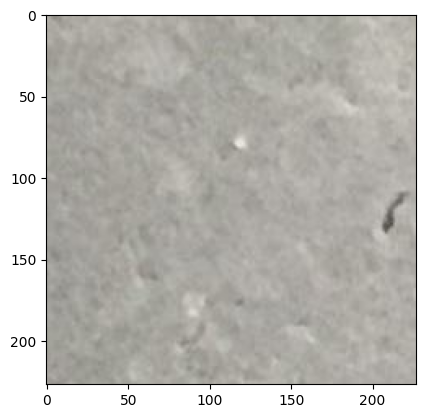

In [ ]:
# 읽어온 이미지 보기
plt.imshow(image)
plt.show()

### 4. glob과 from_tensor_slices , Pipeline 이용하여 이미지 데이터셋 만들기
+ glob활용하여 이미지 패스를 리스트 형태로 만들기
+ from_tensor_slices 활용하여 이미지 패스 리스트를 Dataset 으로 만들기
+ Pipeline 이용하여 map, cache, Shuffle, batch, prefetch 된 Dataset 만들기

In [ ]:
# glob 활용하여 이미지 패스를 만든다.
# glob 결과로 리스트를 리턴

image_paths = glob('./IMAGE/*/*.jpg')

print(len(image_paths))
print(image_paths[-10:])

6000
['./IMAGE/Negative/02455.jpg', './IMAGE/Negative/00863.jpg', './IMAGE/Negative/02874.jpg', './IMAGE/Negative/01023.jpg', './IMAGE/Negative/02378.jpg', './IMAGE/Negative/01845.jpg', './IMAGE/Negative/00284.jpg', './IMAGE/Negative/00187.jpg', './IMAGE/Negative/02169.jpg', './IMAGE/Negative/00320.jpg']


In [ ]:
# 이미지 패스를 주면 이미지 읽고 반환하는 함수

def read_image(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    return image

In [ ]:
# 병렬화
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# 이미지 패스 리스트를 from_tensor_slices 사용하여 데이터셋을 만들고
# map 함수를 사용하여 각 이미지 패스의 이미지들을 병렬로 읽어오기

dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(read_image, num_parallel_calls=AUTOTUNE)

In [ ]:
# 데이터셋에서 1개 이미지 가져오기
tf_image = next(iter(dataset))
tf_image.shape

TensorShape([227, 227, 3])

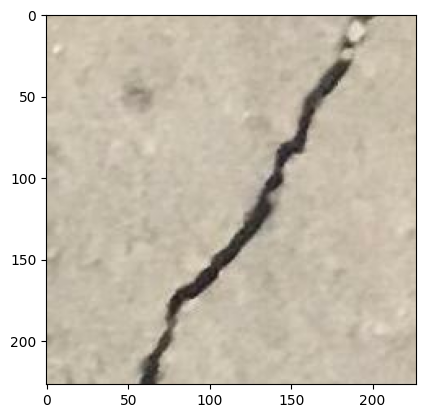

In [ ]:
# Negative 데이터 샘플

plt.imshow(tf_image)
plt.show()

#### ㅇ batch 묶기

In [ ]:
# 이미지 패스의 이미지 읽고(map) 4개 batch 묶기
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(read_image)
dataset = dataset.batch(4)

In [ ]:
# 1개의 mini-batch 가져오기
tf_images = next(iter(dataset))
tf_images.shape

TensorShape([4, 227, 227, 3])

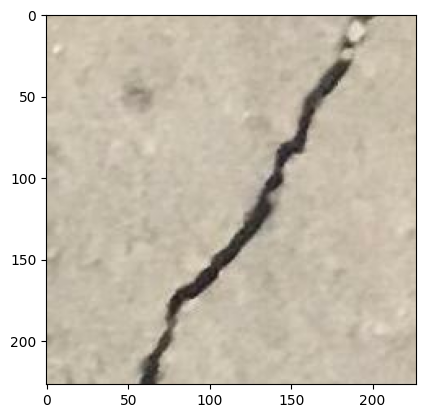

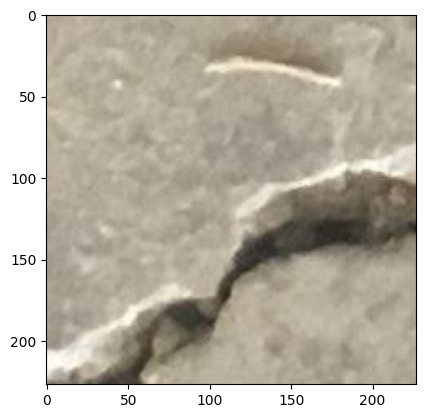

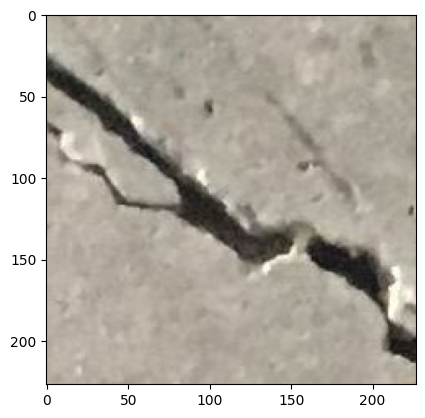

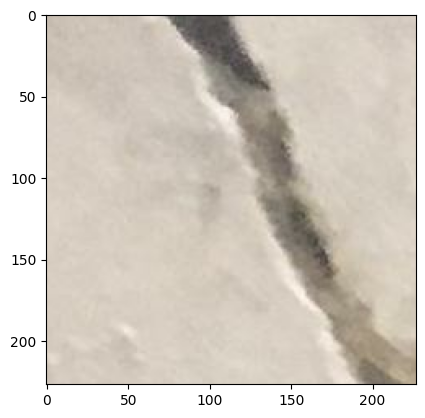

In [ ]:
# Negative 데이터 샘플들

for i in range(4):
    plt.imshow(tf_images[i])
    plt.show()

#### ㅇ cache, Shuffle, batch, prefetch 하기

In [ ]:
# from_tensor_slices > map > cache > batch > shuffle > prefetch 형태로 사용

dataset = tf.data.Dataset.from_tensor_slices(image_paths)  # 입력 : 이미지 패스 리스트
dataset = dataset.map(read_image, num_parallel_calls=AUTOTUNE) # 이미지 패스의 각 이미지 읽기
dataset = dataset.cache()
dataset = dataset.batch(4)
dataset = dataset.shuffle(buffer_size=512)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# shuffle 시간 좀 걸림
tf_images = next(iter(dataset))
tf_images.shape

TensorShape([4, 227, 227, 3])

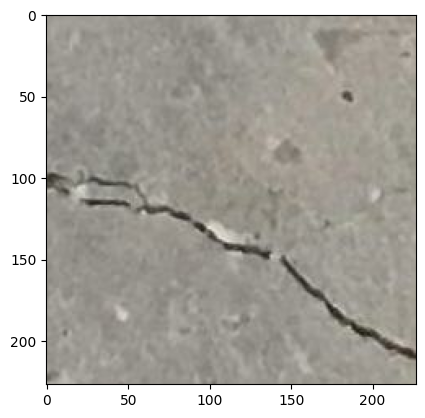

In [ ]:
# shuffle 이전에 첫번째 이미지와 지금은 다른 이미지로 shuffle 되것 확인
plt.imshow(tf_images[0])
plt.show()

## B. 라벨정보 포함한 이미지 데이터셋 만들기(수작업 필요)
### <font color=blue>이미지 데이터만 만들었으나, 지도학습을 위해 이미지 라벨링도 필요하다</font>

#### Data Preprocess : 아래 작업을 손수 작성해야 함
1. glob 이용하여 이미지 패스 읽기
2. shuffle
3. Train/Test 비율로 나누기
4. 이미지 라벨링 만들기
5. from_tensor_slices > map > cache > batch > shuffle > prefetch 파이프라인 사용하여 이미지/라벨링 데이터셋 만들기

In [ ]:
# Hyperparameter Tunning

num_epochs = 10
batch_size = 32

learning_rate = 0.001
dropout_rate = 0.5

input_shape = (227, 227, 3)  # 사이즈 확인
num_classes = 2              # Postive , Negative

In [ ]:
# glob를 통해 이미지 패스 읽어오기
image_paths_list = glob('./IMAGE/*/*.jpg')

In [ ]:
# 리스트 섞어 주기
image_paths = np.random.permutation(image_paths_list)

In [ ]:
# 샘플 이미지 패스 보기
image_paths[:10]

array(['./IMAGE/Negative/00472.jpg', './IMAGE/Positive/00665.jpg',
       './IMAGE/Positive/02269.jpg', './IMAGE/Positive/01094.jpg',
       './IMAGE/Negative/02879.jpg', './IMAGE/Negative/01900.jpg',
       './IMAGE/Negative/00056.jpg', './IMAGE/Negative/00404.jpg',
       './IMAGE/Positive/01797.jpg', './IMAGE/Negative/02451.jpg'],
      dtype='<U26')

In [ ]:
# 8: 2 비율로 Train, Test 이미지셋 나누기

TRAIN_SIZE = int(len(image_paths) * 0.8) # 4,800
train_paths = image_paths[:TRAIN_SIZE]
test_paths = image_paths[TRAIN_SIZE:]

In [ ]:
len(train_paths), len(test_paths)

(4800, 1200)

In [ ]:
# Positive, Negative 폴더 이름 반환하는 함수
# EX) ./IMAGE/Negative/07269.jpg --> /Negative 가져오는 함수 만들기

def get_class_name(path):
    name = os.path.dirname(path).split('/')[-1]  # 폴더명
    return name

In [ ]:
# get_class_name 함수 정상 동작 여부 확인

for path in train_paths[:4]:
  print(path, get_class_name(path))

./IMAGE/Negative/00472.jpg Negative
./IMAGE/Positive/00665.jpg Positive
./IMAGE/Positive/02269.jpg Positive
./IMAGE/Positive/01094.jpg Positive


In [ ]:
# class 이름 만들기

train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)
class_names

array(['Negative', 'Positive'], dtype='<U8')

In [ ]:
# 원핫 인코딩 간단 변환 예제
print( 'Negative' == np.array(['Negative', 'Positive']) )
print( ('Negative' == np.array(['Negative', 'Positive'])).astype(int) )

[ True False]
[1 0]


In [ ]:
# 파일 패스에서 'Negative', 'Positive' 폴더부분을 읽고
# class_name과 비교해서(numpy broadcasting) onehot 만들어 리턴

def get_label(path):
    label_name = tf.strings.split(path, '/')[-2]
    onehot = tf.cast(label_name == class_names, tf.uint8)   # One-Hot-Encoding
    # return tf.argmax(onehot)                         # 이번에는 onehot이 아닌 label 번호로
    return onehot                                      # 이번에는 onehot으로

In [ ]:
# 지정된 패스의 이미지를 읽고 rescale하고 , 원핫 인코딩된 class 라벨을 만들어 이미지와 라벨을 리턴

def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale

    label = get_label(path)
    return image, label

In [ ]:
# 이미지 변환 처리 : 여기서는 사용하지 않음

def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [ ]:
# load_image_label 함수 잘 동작하는지 확인
load_image_label('./IMAGE/Negative/00472.jpg')

(<tf.Tensor: shape=(227, 227, 3), dtype=float32, numpy=
 array([[[0.7176471 , 0.7137255 , 0.69411767],
         [0.7137255 , 0.70980394, 0.6901961 ],
         [0.7019608 , 0.69803923, 0.6784314 ],
         ...,
         [0.6431373 , 0.63529414, 0.6392157 ],
         [0.6431373 , 0.63529414, 0.6392157 ],
         [0.64705884, 0.6392157 , 0.6431373 ]],
 
        [[0.7058824 , 0.7019608 , 0.68235296],
         [0.69803923, 0.69411767, 0.6745098 ],
         [0.6901961 , 0.6862745 , 0.6666667 ],
         ...,
         [0.6313726 , 0.62352943, 0.627451  ],
         [0.63529414, 0.627451  , 0.6313726 ],
         [0.6392157 , 0.6313726 , 0.63529414]],
 
        [[0.7058824 , 0.7019608 , 0.68235296],
         [0.69411767, 0.6901961 , 0.67058825],
         [0.6784314 , 0.6745098 , 0.654902  ],
         ...,
         [0.62352943, 0.6156863 , 0.61960787],
         [0.627451  , 0.61960787, 0.62352943],
         [0.6313726 , 0.62352943, 0.627451  ]],
 
        ...,
 
        [[0.627451  , 0.62352943

In [ ]:
# 병렬화
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# from_tensor_slices > map > cache > batch > shuffle > prefetch 형태로 사용

train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
#train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=512)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(AUTOTUNE)

In [ ]:
# from_tensor_slices > map > cache > batch > prefetch 형태로 사용
# test set은 shuffle 하지 않음

test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(AUTOTUNE)

(227, 227, 3)


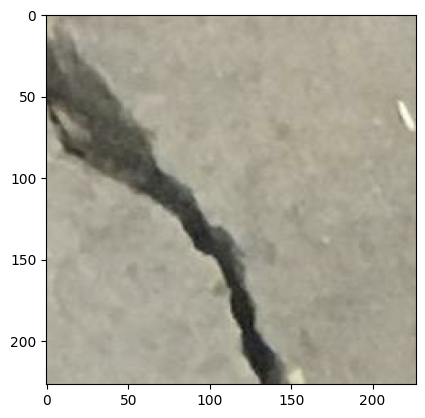

In [ ]:
# 샘플 이미지 확인

i = 0
for batch_img, batch_label in train_dataset.take(1):
  if i == 0 :
    print(batch_img[i].shape)
    plt.imshow(batch_img[i])
  i = i + 1


## C. Build Model

### 1. Build Model

In [ ]:
# Functional API 모델 정의

inputs = tf.keras.layers.Input(input_shape)

net = tf.keras.layers.Conv2D(32, (3, 3), padding='SAME')(inputs)  # 227 X 227 X 32
net = tf.keras.layers.Activation('relu')(net)
net = tf.keras.layers.Conv2D(32, (3, 3), padding='SAME')(net)  # 227 X 227 X 32
net = tf.keras.layers.Activation('relu')(net)
net = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(net)  # 113 X 113 X 32
net = tf.keras.layers.Dropout(dropout_rate)(net)

net = tf.keras.layers.Conv2D(64, (3, 3), padding='SAME')(net)  # 113 X 113 X 64
net = tf.keras.layers.Activation('relu')(net)
net = tf.keras.layers.Conv2D(64, (3, 3), padding='SAME')(net)  # 113 X 113 X 64
net = tf.keras.layers.Activation('relu')(net)
net = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(net)  # 56 X 56 X 64
net = tf.keras.layers.Dropout(dropout_rate)(net)

net = tf.keras.layers.Flatten()(net)  # 200,704
net = tf.keras.layers.Dense(512)(net)
net = tf.keras.layers.Activation('relu')(net)
net = tf.keras.layers.Dropout(dropout_rate)(net)
net = tf.keras.layers.Dense(num_classes)(net)
net = tf.keras.layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [ ]:
# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='categorical_crossentropy',  # Loss Function
              metrics=['accuracy'])  # Metrics / Accuracy

In [ ]:
model.summary()

Model: "Basic_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 227, 227, 32)      896       
                                                                 
 activation (Activation)     (None, 227, 227, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 227, 227, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 227, 227, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 113, 113, 32)      0         
 D)                                                              
                                                         

### 2. Callback

In [ ]:
# callback : EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# ModelCheckpoint
checkpoint_path = "my_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# ReduceLROnPlateau : val_loss가 2번 이상 감소되지 않으면 lr * factor = lr 새로운 lr로 변경해서 학습 진행
lrReducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

### 3. 모델 학습

In [ ]:
# num_epochs = 10
# batch_size = 32
# 데이터 학습시간 오래 걸려, take(10) 사용함 : 정확도 50% 안됨

history = model.fit(
    train_dataset.take(10),
    validation_data=(test_dataset.take(10)),
    epochs=5,
    batch_size=batch_size,
    callbacks=[es, checkpoint, lrReducer]
)

Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 14.0599 - accuracy: 0.4062
Epoch 1: val_loss improved from inf to 0.69296, saving model to my_checkpoint.ckpt
10/10 [==============================] - 23s 919ms/step - loss: 14.0599 - accuracy: 0.4062 - val_loss: 0.6930 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5031
Epoch 2: val_loss did not improve from 0.69296
10/10 [==============================] - 3s 231ms/step - loss: 0.6927 - accuracy: 0.5031 - val_loss: 0.6934 - val_accuracy: 0.4875 - lr: 0.0010
Epoch 3/5
10/10 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5312
Epoch 3: val_loss did not improve from 0.69296
10/10 [==============================] - 2s 220ms/step - loss: 0.6926 - accuracy: 0.5312 - val_loss: 0.6934 - val_accuracy: 0.4875 - lr: 0.0010
Epoch 4/5
10/10 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5250
Epoch 4: val_los

### 4. 성능 그래프

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

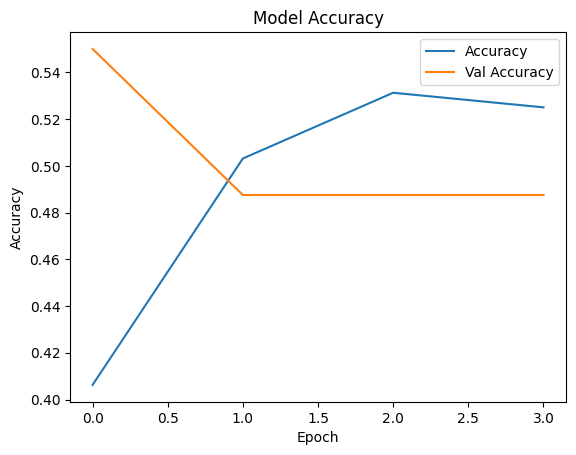

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

### 5. Predict

In [ ]:
# 너무 적은 데이터로 학습하니 성능이 50% 정도 나옴

plt.figure(figsize=(16, 30))
for batch_img, batch_label in test_dataset.take(1):
    for i in range(len(batch_img)):
        pred = model.predict(batch_img[i].numpy().reshape(-1,227, 227, 3))
        pred_t = np.argmax(pred)
        plt.subplot(8, 4, i+1)
        plt.title(f'True Value:{np.argmax(batch_label[i])}, Pred Value: {pred_t}')
        plt.imshow(batch_img[i])
        plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

## 배운 내용 정리
1. glob과 Dataset from_tensor_slices 활용해서 이미지 Dataset 만들어 보았습니다.
2. glob, from_tensor_slices 함수를 이용하여 필요한 데이터를 Dataset 안으로 읽어오고
3. 이미지 파일명 읽어와 화면에 보여주기 : tf.io.read_file , tf.io.decode_image , plt.imshow
4. temsorflow Dataset 활용해서 읽어온 데이터를 파이프라인을 통하여 shuffle, batch, cache, prefetch된 Dataset을 만들수 있다.
5. 모델 학습을 위해서는 라벨 정보도 필요하므로
6. 라벨 정보 포함해서 glob, from_tensor_slices, Pipeline(map, cache, batch, shuffle, prefetch)을 통해 이미지 Dataset을 만들어 CNN 모델링 해 보았습니다.
7. 하지만, glob, from_tensor_slices, Pipelne, 라벨 코딩등 굉장히 번거롭고 수작업이 필요했으며
8. 이런 수작업을 쉽게 해줄 고수준의 API가 있으니 다음 시간에 배워보자.